# UK Crime Data


## Introduction

We have been tasked with taking large data sets, mainly for London, and trying to extract some meaningful information out of them. After doing some exploratory data analysis, and using our data cleaning skills, we will perform some simple hypothesis testing, to see whether or not the data is strong enough to confirm our theories. 

## Data - APIs, CSVs, XLS and PDFs

Our largest data set that we downloaded was in CSV form (https://data.police.uk/data/archive/). It is a massive collection of every crime commited in the UK, and we downloaded from 2011 to 2014, subsetting on London, to make it more managable. It is quite clean but will require a few changes to make it optimal for our use. We also found a CSV file on unemployment, whih 

The APIs we will use will provide us with some useful information that puts our data into better context (https://data.police.uk/docs/method/crime-categories/).

# Hypotheses 

1 - Are variations in the data for violent crime in Camden explained by natural variation?
    Our null hypothesis for this would be p1=p2, where p1,p2 are the proportions of violent crime occuring, in two successive months. 

2 - Has unemployment gone down in London over time? 
    Our null hypothesis for this would be p1=p2, where p1,p2 are the rate for unemployment from year 1 to year 2.

# EDA

In [43]:
import sqlite3
import pandas as pd
import numpy as np
import requests
import pymongo
from pymongo import MongoClient
import json
import data_cleaning as dc
import hypothesis_tests as hyp
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power

Firstly, looking at the large CSV files:


In [2]:
data = pd.read_csv('London Crime Data 2011 to 2014/2011-01-metropolitan-street.csv')

In [3]:
data.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2011-01,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN
1,NaN,2011-01,Metropolitan Police Service,Metropolitan Police Service,0.140619,51.583427,On or near Rams Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN
2,NaN,2011-01,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN
3,NaN,2011-01,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN
4,NaN,2011-01,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN


In [4]:
data.shape

(99099, 12)

In [5]:
data.isna().sum()

Crime ID                 99099
Month                        0
Reported by                  0
Falls within                 0
Longitude                    0
Latitude                     0
Location                     0
LSOA code                    0
LSOA name                    0
Crime type                   0
Last outcome category    99099
Context                  99099
dtype: int64

Looks like 'Crime ID', 'Last outcome category' and 'Context' are useless columns! We'll check to see if they're left empty in other months:

In [6]:
data = pd.read_csv('London Crime Data 2011 to 2014/2013-01-metropolitan-street.csv')
data.shape


(84334, 12)

In [7]:
data.isna().sum()

Crime ID                 21118
Month                        0
Reported by                  0
Falls within                 0
Longitude                 1048
Latitude                  1048
Location                     0
LSOA code                 1048
LSOA name                 1048
Crime type                   0
Last outcome category    21118
Context                  84334
dtype: int64

'Crime ID', 'Last outcome category' and 'Context' are still full of nulls, and we don't need them for our analysis anyway. There are 1048 nulls in this dataset, which are crimes that have no set locations, hence the nulls for all the location parameters. These *will* need dealing with, as we will want to use location as part of our hypotheses.

insert: 2 functions from datacleaning.py that remove the 3 columns, and fill the nulls, and iterate through the whole dataset for it. 

Lets clean up the xls on unemployment:

In [8]:
unemployment_data = pd.read_excel('neets-borough-region.xls', sheet_name ='Annual (16-18)')
unemployment_data

,Unnamed: 0,Unnamed: 1,Numbers,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Rates,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,Code,Borough,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,NaN,2009,2010,2011.000000,2012.0,2013.000000,2014.0,2015.000000
1,E09000001,City of London,0.0,0.0,10.0,0.0,10.0,0.0,0.0,NaN,0.6,0.2,0.900000,0.3,2.900000,0.0,0.000000
2,E09000002,Barking & Dagenham,550.0,480.0,510.0,430.0,460.0,460.0,460.0,NaN,7.9,6.9,6.600000,5.4,5.800000,5.7,5.781410
3,E09000003,Barnet,380.0,350.0,410.0,350.0,230.0,250.0,220.0,NaN,3.8,3.6,4.100000,3.5,2.300000,2.5,2.033547
4,E09000004,Bexley,330.0,300.0,300.0,340.0,360.0,290.0,240.0,NaN,5,4.6,3.400000,4.0,4.200000,3.4,2.757009
5,E09000005,Brent,320.0,320.0,400.0,250.0,300.0,280.0,240.0,NaN,4.6,5,3.900000,2.4,3.000000,2.6,2.239393
6,E09000006,Bromley,450.0,450.0,550.0,430.0,630.0,450.0,360.0,NaN,4.2,4.3,5.200000,4.1,5.800000,4.3,3.432370
7,E09000007,Camden,300.0,310.0,300.0,460.0,190.0,190.0,190.0,NaN,5.5,6.4,7.200000,10.2,4.300000,4.4,4.388006
8,E09000008,Croydon,680.0,560.0,770.0,550.0,450.0,470.0,400.0,NaN,6.9,6.6,6.100000,4.4,3.000000,3.3,2.886741
9,E09000009,Ealing,310.0,290.0,320.0,340.0,340.0,320.0,350.0,NaN,4.9,4.4,3.200000,3.3,3.300000,3.0,3.222807


Lets get rid of the first set of columns, and fix the top row

In [9]:
unemployment_data.drop(['Numbers','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9'],axis=1, inplace = True,)
new_header = unemployment_data.iloc[0] #grab the first row for the header
unemployment_data = unemployment_data[1:] #take the data less the header row
unemployment_data.columns = new_header
unemployment_data

,Code,Borough,2009,2010,2011.0,2012.0,2013.0,2014.0,2015.0
1,E09000001,City of London,0.6,0.2,0.900000,0.3,2.900000,0.0,0.000000
2,E09000002,Barking & Dagenham,7.9,6.9,6.600000,5.4,5.800000,5.7,5.781410
3,E09000003,Barnet,3.8,3.6,4.100000,3.5,2.300000,2.5,2.033547
4,E09000004,Bexley,5,4.6,3.400000,4.0,4.200000,3.4,2.757009
5,E09000005,Brent,4.6,5,3.900000,2.4,3.000000,2.6,2.239393
6,E09000006,Bromley,4.2,4.3,5.200000,4.1,5.800000,4.3,3.432370
7,E09000007,Camden,5.5,6.4,7.200000,10.2,4.300000,4.4,4.388006
8,E09000008,Croydon,6.9,6.6,6.100000,4.4,3.000000,3.3,2.886741
9,E09000009,Ealing,4.9,4.4,3.200000,3.3,3.300000,3.0,3.222807
10,E09000010,Enfield,6.1,5.8,4.200000,4.2,4.200000,3.1,3.521019


# Hypothesis Testing

## Hypothesis One

We want to explore how violent crime has changed over time in London. Is it genuinely getting worse/better or can the variations be explained by normal variation in the data?

So, for example, comparing one month to another, our null hypothesis would be : p1=p2

where p1,p2 are the mean number of violent crimes committed in those months. 

Lets have a look to see how the proportion of violent crime is changing in Camden:

In [10]:
violent_crime_data = pd.DataFrame(columns=['Borough','2011-01','2011-02','2011-03','2011-04','2011-05','2011-06','2011-07','2011-08','2011-09','2011-10','2011-11','2011-12','2012-01','2012-02','2012-03','2012-04','2012-05','2012-06','2012-07','2012-08','2012-09','2012-10','2012-11','2012-12','2013-01','2013-02','2013-03','2013-04','2013-05','2013-06','2013-07','2013-08','2013-09','2013-10','2013-11','2013-12','2014-01','2014-02','2014-03','2014-04','2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12'])
violent_crime_data = violent_crime_data.append({'Borough': 'Camden'}, ignore_index=True)
##create a table for our data

In [11]:
now = []
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
years = ['2011','2012','2013','2014']
dates = []
for y in years:
    for x in months:
        a = hyp.vcp('Camden',y,x)
        now.append(a)
        dates.append('{}-{}'.format(y,x))
        violent_crime_data['2011-{}'.format(x)][0] = a    

#use our function vcp, which returns the proportion of violent crime in any month, and then we iterate through all our data

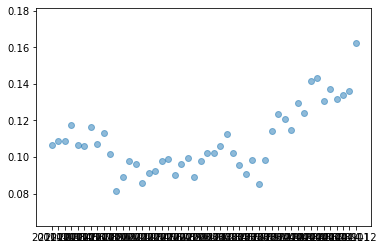

In [12]:
x = dates
y = now
# Plot
plt.scatter(x, y, alpha=0.5)
plt.figure(figsize=(20,10))
plt.title('VCP')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


Obiously need to improve this plot

There seems to be a pretty big jump between October and November 2011 - is this just normal varience or is this a change?

In [13]:
october_data = pd.read_csv('London Crime Data 2011 to 2014/2011-10-metropolitan-street.csv')

violent1 = len(october_data.loc[(october_data['LSOA name'].str.contains("Camden")) & \
                     ((october_data['Crime type'] == "Violent crime")|(october_data['Crime type'] == "Violence and sexual offences"))])

n1 = len(october_data.loc[(october_data['LSOA name'].str.contains("Camden"))])

p1 = violent1/n1

mu1 = n1*p1

var1 = n1*p1*(1-p1)

november_data = pd.read_csv('London Crime Data 2011 to 2014/2011-11-metropolitan-street.csv')

violent2 = len(november_data.loc[(november_data['LSOA name'].str.contains("Camden")) & \
                     ((november_data['Crime type'] == "Violent crime")|(november_data['Crime type'] == "Violence and sexual offences"))])

n2 = len(november_data.loc[(november_data['LSOA name'].str.contains("Camden"))])

p2 = violent2/n2

mu2 = n2*p2

var2 = n2*p2*(1-p2)

print("Dist1 has p {} and sample size {}".format(p1,n1))
print("Dist2 has p {} and sample size {}".format(p2,n2))

Dist1 has p 0.10152890587673197 and sample size 4186
Dist2 has p 0.0815552394499763 and sample size 4218


In [14]:
p_hat = (n1*p1 + n2*p2)/(n1+n2)
critical_value = 1.96

In [15]:
z = (p1-p2)/((p_hat*(1-p_hat)*((1/n1)+(1/n2)))**0.5)
z>1.96

True

We reject the null! If the police officers were trying a new method to tackle violent crime this month, they can see this as genuine evidence that their method is making a difference!

In [16]:
print(violent2)
print(n2)
print(p1)
stats.binom.cdf(k=violent2, n=n2, p=p1, loc=0)
#makes sense we are rejecting, the probability of getting this number of
#violent crimes at the same parameter values as the month before is tiny!

344
4218
0.10152890587673197


5.472003326693572e-06

Try another?

## Hypothesis Two

Have there been genuine changes to the unemployment rate, or are the changes down to natural variation? Lets have a closer look at two of the columns...

In [17]:
unemployment_data.drop([1,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48],inplace=True)
unemployment_data.drop(['Code',2011.0,2012.0,2013.0,2014.0,2015.0],axis=1,inplace=True)
unemployment_data['Differences']=unemployment_data[2010]-unemployment_data[2009]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
unemployment_data

,Borough,2009,2010,Differences
2,Barking & Dagenham,7.9,6.9,-1
3,Barnet,3.8,3.6,-0.2
4,Bexley,5,4.6,-0.4
5,Brent,4.6,5,0.4
6,Bromley,4.2,4.3,0.1
7,Camden,5.5,6.4,0.9
8,Croydon,6.9,6.6,-0.3
9,Ealing,4.9,4.4,-0.5
10,Enfield,6.1,5.8,-0.3
11,Greenwich,6.6,6.2,-0.4


We are going to run a Paired Two Sample T-Test on this data, to see if there has been a genuine fall in unemployment

In [19]:
unemployment_data.Differences.mean()

-0.271875

In [20]:
unemployment_data.Differences.std()

0.4356932740268756

In [21]:
t_stat = (unemployment_data.Differences.mean()-0)/(unemployment_data.Differences.std()/(33)**0.5)
t_stat

-3.584638695687524

In [22]:
p_value = .000554
#from the tables 
#At the 0.05 level, we can reject the null hyp! Good work, unemployment went down genuinely

In [23]:
tt_ind_solve_power(nobs1=33, alpha=0.01, power=0.8, alternative='larger')

0.7968372126774389

With a small sample of 33, the effect sizes that we would be picking up would likely be larger ones! Given, that we have rejected the null hypothesis, we can see that the change from 2009 to 2010 won't be too small... 

In [24]:
cohen_d = (unemployment_data[2010].mean()-unemployment_data[2009].mean())/\
                        (((unemployment_data[2010].std()**2+unemployment_data[2009].std()**2)**0.5)/2)
cohen_d

-0.2810698560212756

A small-medium effect size for the actual data!

## Hypothesis Three

How has crime changed over the years in London? If we take a random sample of crime in random locations in London from 2012, and compare it to a random sample of crime in 2013, how will it have changed? Specifically, lets see if vehicle crime has gotten worse...

Using our API data:

1 - use a random number generator to get a sample of locations around London \
2 - use the API to get all crimes committed in those locations in a month \
3 - use a function to return the number of bicyles thefts out of those crimes  \
4 - repeat for another month \
5 - create two different lists, which will be the number of bicycle thefts in random sample of crimes \
6 - use the welch's t test to see if there has been a change in the amount of bicyle theft in london! 

In [9]:
resp = requests.get('https://data.police.uk/api/crimes-at-location?date=2017-02&lat=52.629729&lng=-1.131592')
crime_data = resp.json()
crime_data
#test, to see how the API works

[{'category': 'anti-social-behaviour',
  'location_type': 'Force',
  'location': {'latitude': '52.629909',
   'street': {'id': 883345, 'name': 'On or near Marquis Street'},
   'longitude': '-1.132073'},
  'context': '',
  'outcome_status': None,
  'persistent_id': '',
  'id': 54732838,
  'location_subtype': '',
  'month': '2017-02'},
 {'category': 'anti-social-behaviour',
  'location_type': 'Force',
  'location': {'latitude': '52.629909',
   'street': {'id': 883345, 'name': 'On or near Marquis Street'},
   'longitude': '-1.132073'},
  'context': '',
  'outcome_status': None,
  'persistent_id': '',
  'id': 54728437,
  'location_subtype': '',
  'month': '2017-02'},
 {'category': 'anti-social-behaviour',
  'location_type': 'Force',
  'location': {'latitude': '52.629909',
   'street': {'id': 883345, 'name': 'On or near Marquis Street'},
   'longitude': '-1.132073'},
  'context': '',
  'outcome_status': None,
  'persistent_id': '',
  'id': 54725957,
  'location_subtype': '',
  'month': '201

In [ ]:
from random import seed
from random import random
crimes = []
for _ in range(25):
    value1 = round(random()*3/10 + 51.3,6)
    value2 = round(random()*4/10 - 0.3,6)
    resp = requests.get('https://data.police.uk/api/crimes-at-location?date=2015-02&lat={}&lng={}'.format(value1,value2))
    crime_data = resp.json()
    for x in range(len(crime_data)):
        crimes.append(crime_data[x])
    count = 0
    for c in crimes:
        if crimes[c]['category'] = "bicycle-theft":
            count += 1
    bicycle_theft.append(count)
    

#this should return us a list of the number of bicycle thefts in random samples of crime
#I would run it twice, for two different lists, but I am now being timed out!

We make up some fake numbers for now, while I get the API working!

In [25]:
bicycle_theft1 = [3,4,2,3,5,4,3,2,4,3,3,4,5,6,1,1,0,0,7,5,4,3,4,3,2]
bicycle_theft2 = [3,4,3,3,2,2,4,4,2,3,2,6,5,1,0,2,3,2,0,1,1,4,5,3,1]

Lets run a welches t test!

(array([2., 2., 3., 7., 6., 3., 2.]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <a list of 7 Patch objects>)

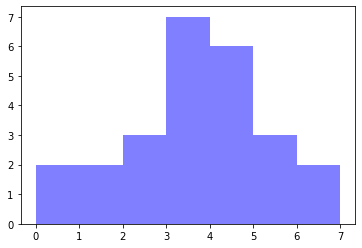

In [27]:
plt.hist(bicycle_theft1, 7, facecolor='blue', alpha=0.5)

(array([2., 4., 6., 6., 4., 2., 1.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

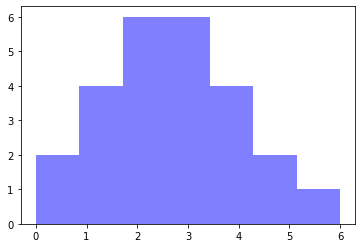

In [29]:
plt.hist(bicycle_theft2, 7, facecolor='blue', alpha=0.5)

They look normal, lets check!

In [34]:
from scipy.stats import normaltest
data = bicycle_theft1
stat, p = normaltest(data)
p

0.9406339333576822

High enough - this is normal enough for Welch's to work!

In [47]:
np.mean(bicycle_theft1)
np.mean(bicycle_theft2)
np.std(bicycle_theft1)
np.std(bicycle_theft2)

1.52

# Conclusion